The point of this notebook is to provide a relatively user-friendly interface for finding passages related to a given passage, via comparison of their OpenAI vector embeddings. I presume that the texts have already been loaded into the Tesserae database and vectorized, following the scripts in the Maximus-bioinformatics notebook. 

In [35]:
from bson import ObjectId
import pandas as pd
from tesserae.db import TessMongoConnection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

connection = TessMongoConnection('127.0.0.1', 27017, None, None, db='maximus')

def load_vectors_from_mongodb(title,unit_type='line'):
    text_id = connection.find('texts',title=title)[0].id
    vectors = pd.DataFrame(connection.aggregate('vectors',[{'$match': {'text': text_id, 'unit_type': unit_type}}, 
                                               {"$project": {"_id": 0, "index": 1, "tags": {"$arrayElemAt": ["$tags", 0]}, "unit_type": 1, "vector": 1}}],
                                              encode=False))
    vectors['title'] = title
    data = np.array([np.array(vector) for vector in vectors['vector']])
    metadata = vectors.T.drop('vector').T
    return data, metadata

def fit_and_transform_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

def find_related(passage,title,unit_type='line',n_components=500,N=15,plot=False):
    if 'phrase' not in passage.keys():
        passage['phrase']=0

    #Load source and target data
    data_s, metadata_s = load_vectors_from_mongodb(passage['title'],unit_type=passage['unit_type'])
    data_t, metadata_t = load_vectors_from_mongodb(title,unit_type=unit_type)
    data = np.vstack((data_s,data_t))

    #Find text id's
    text_s = connection.find('texts',title=passage['title'])[0].id
    text_t = connection.find('texts',title=title)[0].id

    #Reduce to relevant dimensions using PCA
    pca_result = fit_and_transform_pca(data,n_components=n_components)
    pca_result = (pca_result.T/np.linalg.norm(pca_result,axis=1)).T
    N_s = len(data_s)
    data_s = pca_result[:N_s]
    data_t = pca_result[N_s:]

    #Find the text of the source passage and its index, then compute distances
    content = connection.find('units',tags=passage['tag'],text=text_s,unit_type=passage['unit_type'])[passage['phrase']]
    idx = metadata_s.loc[metadata_s['index']==content.index].index[0]
    metadata_t['distance'] = data_t.dot(data_s[idx,:])

    #Plot all distances for reference
    if plot:
        plt.hist(metadata_t['distance'],bins=100)
        plt.show()

    print('Source passage:')
    print(content.snippet)
    print('-----------------')
    print('-----------------')

    #Sort by distance and print
    metadata_sorted = metadata_t.sort_values('distance',ascending=False)
    k = 0
    while k <= N:
        idx_k = metadata_sorted['index'].iloc[k]
        tag_k = metadata_sorted['tags'].iloc[k]
        dist_k = metadata_sorted['distance'].iloc[k]
        text_k = connection.find('units',index=idx_k,text=text_t,unit_type=unit_type)[0].snippet
    
        print(str(k)+'. '+title+' '+tag_k+', distance = '+str(dist_k))
        print(text_k)
        print('-----------------')
        k+=1

    return metadata_sorted

In [42]:
title_id = connection.find('texts',title='Quaestiones ad Thalassium')[0].id
content = connection.find('units',tags='prol.1',text=title_id,unit_type='phrase')[0]
content.snippet

'Φυσικὸν μὲν τοῖς λογικοῖς πέφυκε κάλλος ὁ λόγος· λόγου δὲ κάλλος ἡ κατὰ τὸν λόγον ἀκριβὴς τῶν λογικῶν ἐστι σύνεσις· συνέσεως δὲ κάλλος ἐστὶν ἡ κατὰ τὴν ἀρετὴν σὺν λόγῳ τῶν λογικῶν γόνιμος ἕξις· ταύτης δὲ κάλλος τῆς ἕξεως ἡ περὶ τὴν ἀληθῆ γνῶσιν ἀπλανὴς θεωρία καθέστηκεν, ἧς τέλος ἐστὶν ἡ σοφία, συνέσεως ὑπάρχουσα σαφεστάτη συμπλήρωσις, οἷα δὴ λόγος τυγχάνουσα κατὰ φύσιν τετελεσμένος, ὅστις ἐστὶ νοῦς καθαρός, τῇ περὶ τὴν αἰτίαν ἑνώσει σχέσιν λαβὼν ὑπὲρ νόησιν· καθ᾽ ἥν, ἀποπαύσας τὴν πολυποίκιλον πρὸς τὰ μετὰ τὴν αἰτίαν φυσικὴν αὐτοῦ κίνησίν τε καὶ σχέσιν, μόνης ἀγνώστως ἀντέχεται, κατὰ τὴν ἄφθεγκτον λῆξιν γεγενημένος, τῆς ὑπὲρ νόησιν παμμακαρίστου σιγῆς, ἣν δηλῶσαι παντελῶς οὐ δύναται λόγος ἢ νόησις, ἀλλὰ μόνη κατὰ τὴν μέθεξιν ἡ πεῖρα τῶν ἀξιωθέντων τῆς ὑπὲρ νόησιν ἀπολαύσεως, ἧς σημεῖόν ἐστιν εὔγνωστόν τε καὶ πᾶσι κατάδηλον ἡ κατὰ διάθεσιν πρὸς τὸν αἰῶνα τοῦτον παντελὴς ἀναισθησία τῆς ψυχῆς καὶ διάστασις.'

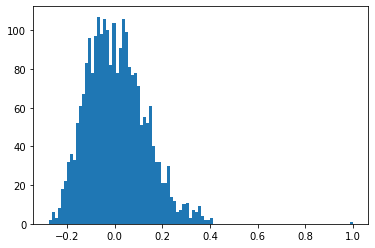

Source passage:
Πλὴν καλὰ γίνεται καὶ τὰ πάθη ἐν τοῖς σπουδαίοις, ὁπηνίκα σοφῶς αὐτὰ τῶν σωματικῶν ἀποστήσαντες, πρὸς τὴν τῶν οὐρανίων μεταχειρίζονται κτῆσιν· οἷον, τὴν μὲν ἐπιθυμίαν τῆς νοερᾶς τῶν θείων ἐφέσεως ὀρεκτικὴν ἐργάσονται κίνησιν, τὴν ἡδονὴν δὲ τῆς ἐπὶ τοῖς θείοις χαρίσμασι τοῦ νοῦ θελκτικῆς ἐνεργείας εὐφροσύνην ἀπήμονα, τὸν δὲ φόβον τῆς μελλούσης ἐπὶ πλημμελήμασι τιμωρίας προφυλακτικὴν ἐπιμέλειαν, τὴν δὲ λύπην διορθωτικὴν ἐπὶ παρόντι κακῷ μεταμέλειαν, καὶ συντόμως  εἰπεῖν, κατὰ τοὺς σοφοὺς τῶν ἰατρῶν, σώματι φθαρτικοῦ θηρὸς τῆς ἐχίδνης τὴν οὖσαν ἢ μελετωμένην ἀφαιρουμένους λώβωσιν, τοῖς  πάθεσι τούτοις πρὸς ἀναίρεσιν χρώμενοι παρούσης κακίας ἢ προσδοκωμένης, καὶ κτῆσιν καὶ φυλακὴν ἀρετῆς τε καὶ γνώσεως.
-----------------
-----------------
0. Quaestiones ad Thalassium 1.5, distance = 1.0000000000000004
Πλὴν καλὰ γίνεται καὶ τὰ πάθη ἐν τοῖς σπουδαίοις, ὁπηνίκα σοφῶς αὐτὰ τῶν σωματικῶν ἀποστήσαντες, πρὸς τὴν τῶν οὐρανίων μεταχειρίζονται κτῆσιν· οἷον, τὴν μὲν ἐπιθυμίαν τῆς νοερ

6. Quaestiones ad Thalassium 64.14, distance = 0.3792426604410621
Εἰ δὲ πρὸς τὴν τοῦ καθ᾽ ἕκαστον θεωρίαν τὴν Νινευὴ νοοῦμεν, τὴν ἑκάστου ψυχὴν εἶναί φαμεν τὴν πόλιν  τὴν μεγάλην, πρὸς ἣν ἀποστέλλεται παρανομοῦσαν ὁ τοῦ Θεοῦ Λόγος, κηρύξων μετάνοιαν πρὸς ζωήν· ταύτης δὲ βασιλέα νοοῦμεν τὸν νοῦν, ἄρχοντας δὲ τὰς ἐμφύτους δυνάμεις, ἀνθρώπους δὲ τοὺς ἐμπαθεῖς λογισμούς, κτήνη δὲ τὰ περὶ τὸ σῶμα κατ᾽ ἐπιθυμίαν κινήματα, βόας δὲ τὰς κατὰ τὸν θυμὸν περὶ τὰ ὑλικὰ πλεονεκτικὰς κινήσεις, πρόβατα δὲ τὰ κατὰ τὴν αἴσθησιν χωρὶς διανοίας ἀντιληπτικὰ τῶν αἰσθητῶν κινήματα, καὶ τὸν μὲν βασιλέα νοῦν, ὡς ἀπὸ θρόνου τινός, τῆς κατὰ τὴν προτέραν ἄγνοιαν ἐξανιστάμενον ἕξεως καί, ὥσπερ στολήν, τὴν ψευδῆ περὶ τῶν ὄντων δόξαν ἀποτιθέμενον καί, ὡς σάκκον, περιβαλλόμενον τὸν ἐπὶ τοῖς κακῶς φρονηθεῖσι μετάμελον καὶ ἐπὶ σποδοῦ καθήμενον τῆς κατὰ τὴν πτωχείαν τοῦ πνεύματος ἕξεως καὶ προστάσσοντα τοῖς ἀνθρώποις καὶ τοῖς κτήνεσι καὶ τοῖς βουσὶ καὶ τοῖς προβάτοις νηστεύειν τῆς τε κατὰ κακίαν βρώσεως καὶ τῆς κατὰ τὴν

14. Quaestiones ad Thalassium 43.7, distance = 0.35816057032434695
Ἐὰν μὲν οὖν ὁ ἄνθρωπος μόνης τῆς καθ᾽ ἡδονὴν καὶ ὀδύνην αἰσθητικῆς τῶν σωμάτων γένηται διακρίσεως, τὴν θείαν παραβὰς ἐντολήν, ἐσθίει τὸ ξύλον τὸ γνωστὸν καλοῦ τε καὶ πονηροῦ, τουτέστι τὴν κατ᾽ αἴσθησιν ἀλογίαν, μόνην ἔχων τὴν συστατικὴν τῶν σωμάτων διάκρισιν, καθ᾽ ἥν, ὡς μὲν καλοῦ, τῆς ἡδονῆς ἀντέχεται, ὡς δὲ κακοῦ, τῆς ὀδύνης ἀπέχεται· ἐὰν δὲ μόνης τῆς τῶν αἰωνίων διακρινούσης τὰ πρόσκαιρα διόλου νοερᾶς γένηται διακρίσεως, τὴν θείαν φυλάξας ἐντολήν, ἐσθίει τὸ ξύλον τῆς ζωῆς, τὴν κατὰ νοῦν λέγω συνισταμένην σοφίαν, μόνην ἔχων τὴν συστατικὴν τῆς ψυχῆς διάκρισιν, καθ᾽ ἥν, ὡς μὲν καλοῦ, τῆς τῶν αἰωνίων ἀντέχεται δόξης, ὡς δὲ κακοῦ, τῆς τῶν προσκαίρων ἀπέχεται φθορᾶς.
-----------------
15. Quaestiones ad Thalassium 63.11, distance = 0.35733142977665555
Τὴν μὲν οὖν κάθαρσιν τοῖς ἀξίοις τῆς τῶν ἀρετῶν καθαρότητος διὰ φόβου καὶ εὐσεβείας καὶ γνώσεως ποιεῖται τὸ Πνεῦμα τὸ ἅγιον, τὸν δὲ φωτισμὸν τῆς τῶν ὄντων καθ᾽ οὓς ὑπάρχουσι 

In [47]:
passage = {'title': 'Quaestiones ad Thalassium', 'tag': '1.5', 'phrase': 0, 'unit_type':'phrase'}
metadata = find_related(passage,'Quaestiones ad Thalassium',unit_type='phrase',plot=True)

It seems to work, but it's extremely slow

# Bulk computation

Now, I'll try to embed all the matches from an entire pair of texts, using the "Match" entity from tesserae

First, I need to correct the embedding database, to include the unit id

In [17]:
def add_unit_id(text,unit_type):
    indices = pd.DataFrame(connection.aggregate('units',[{'$match': {'text': text.id, 'unit_type': unit_type}}, {"$project": {"_id": 1, "index": 1}}],encode=False)).set_index('index')
    vectors = connection.find('vectors',text=text.id,unit_type=unit_type)
    for vector in vectors:
        vector.unit = indices['_id'].loc[vector.index]
    out = connection.update(vectors)
    return out

In [19]:
for text in connection.find('texts'):
    print(text.title)
    print(add_unit_id(text,'line'))
    print(add_unit_id(text,'phrase'))

Liber asceticus
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 129, 'nModified': 129, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 642, 'nModified': 642, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
Quaestiones ad Thalassium
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 1216, 'nModified': 1216, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 2464, 'nModified': 2464, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
Capita de caritate
BulkWriteResult({'writeErrors': [], 'writeConcernErrors': [], 'nInserted': 0, 'nUpserted': 0, 'nMatched': 402, 'nModified': 402, 'nRemoved': 0, 'upserted': []}, acknowledged=True)
BulkWriteResult({'writeErrors': [],

In [19]:
t = np.random.rand(5)
np.logical_and(t > .2,t <0.9)

array([ True,  True,  True, False, False])

In [38]:
from bson import ObjectId
import pandas as pd
from tesserae.db import TessMongoConnection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tesserae.db.entities import Match

connection = TessMongoConnection('127.0.0.1', 27017, None, None, db='maximus')

def load_vectors_from_mongodb(title,unit_type='line'):
    text_id = connection.find('texts',title=title)[0].id
    vectors = pd.DataFrame(connection.aggregate('vectors',[{'$match': {'text': text_id, 'unit_type': unit_type}}, 
                                               {"$project": {"_id": 0, "unit": 1, "vector": 1}}],
                                              encode=False))
    data = np.array([np.array(vector) for vector in vectors['vector']])
    units = vectors['unit'].values
    return data, units

def fit_and_transform_pca(data, n_components=50):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(data)

def find_all_related(title_s,title_t,unit_s='line',unit_t='line',cutoff=0.5,n_components='mle',plot=False):
    #Load source and target data
    data_s, units_s = load_vectors_from_mongodb(title_s,unit_type=unit_s)
    data_t, units_t = load_vectors_from_mongodb(title_t,unit_type=unit_t)
    data = np.vstack((data_s,data_t))

    #Reduce to relevant dimensions using PCA
    pca = PCA(n_components=n_components)
    pca.fit(data)
    pca_result = pca.transform(data)
    pca_result = (pca_result.T/np.linalg.norm(pca_result,axis=1)).T
    N_s = len(data_s)
    N_t = len(data_t)
    indices = np.indices((N_s,N_t))
    data_s = pca_result[:N_s]
    data_t = pca_result[N_s:]
    distances = data_s.dot(data_t.T)
    
    if cutoff > 1:
        cutoff = cutoff*np.std(distances)
        
    mask = np.logical_and(distances>cutoff,distances<.99)
    
    scores = distances[mask]
    source_units = units_s[indices[0][mask]]
    target_units = units_t[indices[1][mask]]
    
    if plot:
        plt.hist(distances.reshape(-1),bins=100)
        plt.show()
        plt.plot(pca.singular_values_)
        plt.show()
        print(np.std(distances))
    
    matches = [Match(source_unit=su,target_unit=tu,score=s) for (su, tu, s) in zip(source_units,target_units,scores)]
    out = connection.insert(matches)
    return out

In [ ]:
for text1 in connection.find('texts'):
    for text2 in connection.find('texts'):
        out = find_all_related(text1.title,text2.title,n_components=0.9,cutoff=4)
        print(text1.title)
        print(text2.title)
        if len(out)>0:
            print(str(len(out))+' inserted')
        else:
            print('No matches')
        print('-----')

Liber asceticus
Liber asceticus
No matches
-----
Liber asceticus
Quaestiones ad Thalassium
20 inserted
-----
Liber asceticus
Capita de caritate
15 inserted
-----
Liber asceticus
Expositio in Psalmum LIX
No matches
-----
Liber asceticus
Orationis dominicae expositio
No matches
-----
Liber asceticus
Capita theologica et oeconomica
2 inserted
-----
Liber asceticus
Mystagogia
No matches
-----
Liber asceticus
Quaestiones ad Theopemptum
No matches
-----
Liber asceticus
Epistulae
1 inserted
-----
Liber asceticus
Opuscula
8 inserted
-----
Liber asceticus
To Anastasius the Monk
No matches
-----
Liber asceticus
Disputatio cum Pyrrho
2 inserted
-----
Liber asceticus
Capita XV
22 inserted
-----
Liber asceticus
Ambigua ad Thomam
No matches
-----
Liber asceticus
Ambigua ad Iohannem
2 inserted
-----
Liber asceticus
Quaestiones et dubia
4 inserted
-----
Liber asceticus
New Testament
1418 inserted
-----
Liber asceticus
Old Testament
2178 inserted
-----
Liber asceticus
Isagoge
No matches
-----
Liber asc

In [27]:
out

[Match(search_id=None, source_unit=65f2e97cc2dcb7e33d4f793f, target_unit=65f2e9c1c2dcb7e33d5063ac, source_tag=source, target_tag=target, matched_features=[], score=0.4744954402119703, source_snippet=, target_snippet=, highlight=None),
 Match(search_id=None, source_unit=65f2e97cc2dcb7e33d4f793f, target_unit=65f2e9c1c2dcb7e33d5063ae, source_tag=source, target_tag=target, matched_features=[], score=0.4542914489052477, source_snippet=, target_snippet=, highlight=None),
 Match(search_id=None, source_unit=65f2e97cc2dcb7e33d4f795d, target_unit=65f2e9c1c2dcb7e33d5063ca, source_tag=source, target_tag=target, matched_features=[], score=0.4845131801291439, source_snippet=, target_snippet=, highlight=None),
 Match(search_id=None, source_unit=65f2e97cc2dcb7e33d4f795e, target_unit=65f2e9c1c2dcb7e33d5062af, source_tag=source, target_tag=target, matched_features=[], score=0.44507294315853724, source_snippet=, target_snippet=, highlight=None),
 Match(search_id=None, source_unit=65f2e97cc2dcb7e33d4f7961

In [15]:
for item in m:
    print(connection.find('units',_id=item.source_unit)[0].snippet)
    print('')
    print(connection.find('units',_id=item.target_unit)[0].snippet)
    print('---')

Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρόπου, καθ᾽ ὃν ἡ τοῦ λόγου δύναμις διὰ παντὸς ἀκμάζουσα συντηρεῖν πέφυκε τὴν μνήμην ἀπαθῆ καὶ ἀμείωτον. Ὅσον δὲ τοῦ ἁπλῶς ἀκούειν  τὸ καὶ διαμονὴν ἀκαθ

Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρόπου, καθ᾽ ὃν ἡ τοῦ λόγου δύναμις διὰ παντὸς ἀκμάζουσα συντηρεῖν πέφυκε τὴν μνήμην ἀπαθῆ καὶ ἀμείωτον. Ὅσον δὲ τοῦ ἁπλῶς ἀκούειν  τὸ καὶ διαμονὴν ἀκαθ

Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρόπου, καθ᾽ ὃν ἡ τοῦ λόγου δύναμις διὰ παντὸς ἀκμάζουσα συντηρεῖν πέφυκε τὴν μνήμην ἀπαθῆ καὶ ἀμείωτον. Ὅσον δὲ τοῦ ἁπλῶς ἀκούειν  τὸ καὶ διαμονὴν ἀκαθ

υἱὸς σοφὸς εὐφραίνει πατέρα, υἱὸς δὲ ἄφρων μυκτηρίζει μητέρα αὐτοῦ.
---
Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρόπου, καθ᾽ ὃν ἡ τοῦ λόγου δύναμις διὰ παντὸς ἀκμάζουσα συντηρεῖν πέφυκε τὴν μν

ὅτι ἐν πλήθει σοφίας πλῆθος γνώσεως, καὶ ὁ προστιθεὶς γνῶσιν προσθήσει ἄλγημα.
---
Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρόπου, καθ᾽ ὃν ἡ τοῦ λόγου δύναμις διὰ παντὸς ἀκμάζουσα συντηρεῖν πέ

εἶπα δὲ ὅτι Ὁ χρόνος ἐστὶν ὁ λαλῶν, ἐν πολλοῖς δὲ ἔτεσιν οἴδασιν σοφίαν.
---
Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρόπου, καθ᾽ ὃν ἡ τοῦ λόγου δύναμις διὰ παντὸς ἀκμάζουσα συντηρεῖν πέφυκε τ

Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρόπου, καθ᾽ ὃν ἡ τοῦ λόγου δύναμις διὰ παντὸς ἀκμάζουσα συντηρεῖν πέφυκε τὴν μνήμην ἀπαθῆ καὶ ἀμείωτον. Ὅσον δὲ τοῦ ἁπλῶς ἀκούειν  τὸ καὶ διαμονὴν ἀκαθ

διὰ τοῦτο ἰδοὺ ἐγὼ προσθήσω τοῦ μεταθεῖναι τὸν λαὸν τοῦτον καὶ μεταθήσω αὐτοὺς καὶ ἀπολῶ τὴν σοφίαν τῶν σοφῶν καὶ τὴν σύνεσιν τῶν συνετῶν κρύψω.
---
Πῶς σοφώτερος γίνεται λαβὼν ἀφορμὴν ὁ σοφός, καὶ δίκαιος γνοὺς προσθήσει τοῦ δέχεσθαι, κατὰ τὴν θείαν παροιμίαν, σαφῶς αὐτός, πάντων μοι τιμιώτατε, κατ᾽ αὐτὴν ἔδειξας τὴν πεῖραν, ἔργῳ διδάξας ὅπερ ὁ θεῖος σοφῶς ὑπαινίσσεται λόγος. Ἅπαξ γὰρ ἀκούσας μου κατ᾽ ἐπιδρομὴν ἐπιτόμως, ὡς οἷόν τε ἦν, ἀφηγουμένου τὰ ἄλλῳ τινὶ μεγάλῳ γέροντι, καὶ ὄντως τὰ θεῖα σοφῷ περί τε τῆς ἁγίας Ἐκκλησίας, καὶ τῆς ἐν αὐτῇ ἐπιτελουμένης ἁγίας συνάξεως καλῶς τε καὶ μυστικῶς θεωρηθέντα, καὶ ὡς ἐνῆν μάλιστα διδασκαλικῶς, ἀπῄτεις με κατεπείγων ἐξ αὐτῆς ἔγγραφόν σοι ποιεῖσθαι τὴν τούτων διήγησιν, λήθης φάρμακον καὶ βοήθειαν μνήμης ἔχειν τὸ γράμμα βεβουλημένος, φυσικῶς τὸν χρόνον ἐχούσης φάσκων δαμάζοντα· καὶ ἀνεπαισθήτως διὰ λήθης τῶν ἐναποκειμένων συλᾷν τε καὶ ἀφανίζειν παντελῶς τοὺς τύπους καὶ τὰς εἰκόνας δυνάμενον, καὶ διὰ τοῦτο πάντως δεομένης τοῦ ἀνακαινίζοντος τρό

Οὐ πάντα δὲ τὰ τῷ μακαρίῳ γέροντι μυστικῶς θεωρηθέντα λέγειν καθεξῆς ἐπαγγέλλομαι· οὐδ᾽ αὐτὰ τὰ λεγόμενα, ὡς ἐνοήθη τε παρ᾽ ἐκείνου καὶ ἐλέχθη. Ἐκεῖνος γάρ, πρὸς τὸ φιλόσοφος εἶναι καὶ πάσης παιδείας διδάσκαλος, δι᾽ ἀρετῆς περιουσίαν καὶ τῆς περὶ τὰ θεῖα χρονιωτέρας τε καὶ ἐπιστημονικωτέρας τριβῆς καὶ φιλοπονίας, τῶν τῆς ὕλης δεσμῶν καὶ τῶν κατ᾽ αὐτὴν φαντασιῶν ἐλεύθερον ἑαυτὸν καταστήσας, τόν τε νοῦν εἰκότως εἶχε ταῖς θείαις αὐγαῖς περιλαμπόμενον, καὶ διὰ τοῦτο δυνάμενον εὐθέως ὁρᾷν τὰ τοῖς πολλοῖς μὴ ὁρώμενα, καὶ τὸν λόγον ἑρμηνευτὴν ἀκριβέστατον τῶν νοηθέντων· καὶ ἐσόπτρου δίκην ὑπ᾽ οὐδεμιᾶς κηλίδος παθῶν ἐμποδιζόμενον, ἀκραιφνῶς τὰ ἄλλοις μήτε νοηθῆναι δυνάμενα, καὶ φέρειν καὶ λέγειν ἰσχύοντα, ὡς δύνασθαι τοὺς ἀκροατὰς ὅλον μὲν τῷ λόγῳ τὸν νοῦν ὁρᾷν ἐποχούμενον· ὅλα δὲ ὅλῳ τῷ νῷ καθαρῶς ἐμφαίνεσθαι τὰ νοηθέντα καὶ διὰ τῆς τοῦ λόγου μεσιτείας αὐτοῖς διαπορθμευόμενα δέξασθαι· ἀλλ᾽ ὅσα διὰ μνήμης τε φέρω, καὶ ὡς νοεῖν ἀμυδρῶς καὶ λέγειν ἀμυδρότερον δύναμαι, πλὴν εὐσεβῶς χάριτι τοῦ τὰ 

Καὶ ἔμπαλιν Ἐκκλησίαν μυστικὴν τὸν ἄνθρωπον, ὡς διὰ ναοῦ μὲν τοῦ σώματος τὸ πρακτικὸν τῆς ψυχῆς ταῖς τῶν ἐντολῶν ἐνεργείαις κατὰ τὴν ἠθικὴν φιλοσοφίαν ἐναρέτως φαιδρύνοντα· ὡς δι᾽ ἱερατείου δὲ τῆς ψυχῆς τοὺς κατ᾽ αἴσθησιν λόγους καθαρῶς ἐν Πνεύματι τῆς ὕλης περιτμηθέντας κατὰ τὴν φυσικὴν θεωρίαν διὰ λόγου τῷ Θεῷ προσκομίζοντα, καὶ ὡς διὰ θυσιαστηρίου τοῦ νοός, τὴν ἐν ἀδύτοις πολυύμνητον τῆς ἀφανοῦς καὶ ἀγνώστου μεγαλοφωνίας σιγὴν τῆς θεότητος δι᾽ ἄλλης λάλου τε καὶ πολυφθόγγου σιγῆς προσκαλούμενον, καὶ ὡς ἐφικτὸν ἀνθρώπῳ κατὰ μυστικὴν θεολογίαν αὐτῇ συγγινόμενον, καὶ τοιοῦτον γινόμενον οἷον εἰκὸς εἶναι δεῖ τὸν ἐπιδημίας ἀξιωθέντα Θεοῦ, καὶ ταῖς αὐτοῦ παμφαέσιν αἴγλαις ἐνσημανθέντα.

διὰ τοῦτο ἀδυνατήσουσιν ἐν αὐτοῖς πολλοὶ καὶ πεσοῦνται καὶ συντριβήσονται, καὶ ἐγγιοῦσιν καὶ ἁλώσονται ἄνθρωποι ἐν ἀσφαλείᾳ ὄντες.
---
Καὶ ἔμπαλιν Ἐκκλησίαν μυστικὴν τὸν ἄνθρωπον, ὡς διὰ ναοῦ μὲν τοῦ σώματος τὸ πρακτικὸν τῆς ψυχῆς ταῖς τῶν ἐντολῶν ἐνεργείαις κατὰ τὴν ἠθικὴν φιλοσοφίαν ἐναρέτως φαιδρύνοντα· 

Ἐπειδὴ γὰρ ἐκ νοερᾶς καὶ ζωτικῆς δυνάμεως καθολικῶς συνίστασθαι τὴν ψυχὴν ἔφασκε· καὶ τῆς μὲν νοερᾶς ἐξουσιαστικῶς κατὰ βούλησιν κινουμένης, τῆς δὲ ζωτικῆς κατὰ φύσιν ἀπροαιρέτως, ὡς ἔχει, μενούσης. Καὶ πάλιν, τῆς μὲν νοερᾶς εἶναι τό τε θεωρητικόν, καὶ τὸ πρακτικόν· καὶ τὸ μὲν θεωρητικὸν καλεῖσθαι νοῦν ἔλεγε· τὸ δὲ πρακτικόν, λόγον· καὶ τῆς μὲν νοερᾶς δυνάμεως κινητικὸν εἶναι τὸν νοῦν, τῆς δὲ ζωτικῆς προνοητικὸν ὑπάρχειν τὸν λόγον· καὶ τὸν μὲν εἶναί τε καὶ καλεῖσθαι σοφίαν, φημὶ δὲ τὸν νοῦν, ὅταν παντάπασιν ἀτρέπτους ἑαυτοῦ διαφυλάττῃ τὰς πρὸς τὸν Θεὸν κινήσεις· τὸν δὲ λόγον ὡσαύτως φρόνησιν καὶ εἶναι καὶ καλεῖσθαι, ὅταν σωφρόνως τὴν ὑπ᾽ αὐτοῦ κατὰ πρόνοιαν διοικουμένην ζωτικὴν δύναμιν ταῖς ἐνεργείαις συνάψας τῷ νῷ δείξειεν ἀδιάφορον· τὴν αὐτὴν αὐτῷ καὶ  ὁμοίαν δι᾽ ἀρετῆς ἔμφασιν τοῦ θείου φέρουσαν, ἣν καὶ ἐπιμερίζεσθαι τῷ τε νῷ καὶ τῷ λόγῳ φυσικῶς ἔλεγεν· ὡς εἶναι μᾶλλον καὶ συνισταμένη δείκνυσθαι προηγουμένως τὴν ψυχὴν ἐκ τοῦ νοῦ καὶ τοῦ λόγου, ὡς νοεράν τε καὶ λογικήν· τῆς ζωτικῆς ἐ

ἐν νόμῳ παραδοθήσονται, ἐν θησαυροῖς ἡ σωτηρία ἡμῶν, ἐκεῖ σοφία καὶ ἐπιστήμη καὶ εὐσέβεια πρὸς τὸν κύριον· οὗτοί εἰσιν θησαυροὶ δικαιοσύνης.
---
Καί, [ὡς] σαφέστερον περὶ τούτων εἰπεῖν, τῆς ψυχῆς τὸ μὲν ἔλεγε εἶναι θεωρητικόν, καθὼς εἴρηται, τὸ δὲ πρακτικόν· καὶ τὸ μὲν θεωρητικὸν ἐκάλει νοῦν, τὸ δὲ πρακτικόν, λόγον, ὡς πρώτας δηλαδὴ δυνάμεις τῆς ψυχῆς· καὶ πάλιν τὸν νοῦν, σοφίαν, τὸν δὲ λόγον, φρόνησιν, ὡς πρώτας ἐνεργείας. Διεξοδικῶς δὲ πάλιν τὴν ψυχὴν ἔφασκεν εἶναι, κατὰ μὲν τὸ νοερόν, τὸν νοῦν, τὴν σοφίαν, τὴν θεωρίαν, τὴν γνῶσιν, τὴν ἄληστον γνῶσιν, τούτων δὲ τέλος εἶναι τὴν ἀλήθειαν· κατὰ δὲ τὸ λογικόν, τὸν λόγον, τὴν φρόνησιν, τὴν πρᾶξιν, τὴν ἀρετήν, τὴν πίστιν, τούτων δὲ τέλος εἷναι τὸ ἀγαθόν.

ἢ ψυχή, ἥτις ἐὰν ἅψηται παντὸς πράγματος ἀκαθάρτου, ἢ θνησιμαίου ἢ θηριαλώτου ἀκαθάρτου ἢ τῶν θνησιμαίων ἢ τῶν βδελυγμάτων τῶν ἀκαθάρτων ἢ τῶν θνησιμαίων κτηνῶν τῶν ἀκαθάρτων,
---
Καί, [ὡς] σαφέστερον περὶ τούτων εἰπεῖν, τῆς ψυχῆς τὸ μὲν ἔλεγε εἶναι θεωρητικόν, καθὼς εἴρηται, τὸ δὲ πρακτι

ἀρχὴ σοφίας φόβος κυρίου, σύνεσις ἀγαθὴ πᾶσι τοῖς ποιοῦσιν αὐτήν. ἡ αἴνεσις αὐτοῦ μένει εἰς τὸν αἰῶνα τοῦ αἰῶνος.
---
Τὸν γὰρ νοῦν διὰ τῆς σοφίας ἔφασκε κινούμενον, εἰς θεωρίαν ἰέναι· διὰ δὲ τῆς θεωρίας, εἰς γνῶσιν· διὰ δὲ τῆς γνώσεως, εἰς ἄληστον γνῶσιν· διὰ δὲ τῆς ἀλήστου γνώσεως, εἰς τὴν ἀλήθειαν· περὶ ἣν ὁ νοῦς ὅρον τῆς κινήσεως δέχεται, περιγραφομένης αὐτῷ τῆς τε οὐσίας καὶ τῆς δυνάμεως καὶ τῆς ἕξεως καὶ τῆς ἐνεργείας.

γνῶναι σοφίαν καὶ παιδείαν νοῆσαί τε λόγους φρονήσεως
---
Τὸν γὰρ νοῦν διὰ τῆς σοφίας ἔφασκε κινούμενον, εἰς θεωρίαν ἰέναι· διὰ δὲ τῆς θεωρίας, εἰς γνῶσιν· διὰ δὲ τῆς γνώσεως, εἰς ἄληστον γνῶσιν· διὰ δὲ τῆς ἀλήστου γνώσεως, εἰς τὴν ἀλήθειαν· περὶ ἣν ὁ νοῦς ὅρον τῆς κινήσεως δέχεται, περιγραφομένης αὐτῷ τῆς τε οὐσίας καὶ τῆς δυνάμεως καὶ τῆς ἕξεως καὶ τῆς ἐνεργείας.

τῶνδε γὰρ ἀκούσας σοφὸς σοφώτερος ἔσται, ὁ δὲ νοήμων κυβέρνησιν κτήσεται
---
Τὸν γὰρ νοῦν διὰ τῆς σοφίας ἔφασκε κινούμενον, εἰς θεωρίαν ἰέναι· διὰ δὲ τῆς θεωρίας, εἰς γνῶσιν· διὰ δὲ τῆς γνώσεως, εἰς ἄλη

ὅτι πολλὴ ἡ σοφία τοῦ κυρίου· ἰσχυρὸς ἐν δυναστείᾳ καὶ βλέπων τὰ πάντα,
---
Τὸν γὰρ νοῦν διὰ τῆς σοφίας ἔφασκε κινούμενον, εἰς θεωρίαν ἰέναι· διὰ δὲ τῆς θεωρίας, εἰς γνῶσιν· διὰ δὲ τῆς γνώσεως, εἰς ἄληστον γνῶσιν· διὰ δὲ τῆς ἀλήστου γνώσεως, εἰς τὴν ἀλήθειαν· περὶ ἣν ὁ νοῦς ὅρον τῆς κινήσεως δέχεται, περιγραφομένης αὐτῷ τῆς τε οὐσίας καὶ τῆς δυνάμεως καὶ τῆς ἕξεως καὶ τῆς ἐνεργείας.

πᾶς συνετὸς ἔγνω σοφίαν καὶ τῷ εὑρόντι αὐτὴν δώσει ἐξομολόγησιν.
---
Τὸν γὰρ νοῦν διὰ τῆς σοφίας ἔφασκε κινούμενον, εἰς θεωρίαν ἰέναι· διὰ δὲ τῆς θεωρίας, εἰς γνῶσιν· διὰ δὲ τῆς γνώσεως, εἰς ἄληστον γνῶσιν· διὰ δὲ τῆς ἀλήστου γνώσεως, εἰς τὴν ἀλήθειαν· περὶ ἣν ὁ νοῦς ὅρον τῆς κινήσεως δέχεται, περιγραφομένης αὐτῷ τῆς τε οὐσίας καὶ τῆς δυνάμεως καὶ τῆς ἕξεως καὶ τῆς ἐνεργείας.

Πᾶσα σοφία φόβος κυρίου, καὶ ἐν πάσῃ σοφίᾳ ποίησις νόμου·
---
Τὸν γὰρ νοῦν διὰ τῆς σοφίας ἔφασκε κινούμενον, εἰς θεωρίαν ἰέναι· διὰ δὲ τῆς θεωρίας, εἰς γνῶσιν· διὰ δὲ τῆς γνώσεως, εἰς ἄληστον γνῶσιν· διὰ δὲ τῆς ἀλήστου γνώσεως, εἰς τ

Νοῦ γὰρ ἔλεγε δύναμιν εἶναι τὴν σοφίαν, καὶ αὐτὸν εἶναι τὸν νοῦν δυνάμει σοφίαν· τὴν δὲ θεωρίαν, ἕξιν· τὴν δὲ γνῶσιν, ἐνέργειαν· τὴν δὲ ἄληστον γνῶσιν, σοφίας τε καὶ θεωρίας καὶ γνώσεως, ἤγουν δυνάμεως καὶ ἕξεως καὶ ἐνεργείας, τὴν περὶ τὸ  γνωστὸν τὸ ὑπὲρ πᾶσαν τὴν γνῶσιν ἀκατάληκτον καὶ ἑκτικὴν ἀεικινησίαν, ἧς πέρας ἐστίν, ὡς ἀλάθητον γνωστόν, ἡ ἀλήθεια· ὃ καὶ θαυμάζειν ἄξιον, πῶς τὸ ἄληστον λήγει περιγραφόμενον, ἢ δηλονότι ὡς Θεῷ τῇ ἀληθείᾳ περατούμενον· Θεὸς γὰρ ἡ ἀλήθεια περὶ ὃν ἀκαταλήκτως τε καὶ ἀλήστως κινούμενος ὁ νοῦς, λήγειν οὐκ ἔχει ποτὲ τῆς κινήσεως, μὴ εὑρίσκων πέρας ἔνθα μὴ ἔστι διάστημα. Τὸ γὰρ θαυμαστὸν μέγεθος τῆς θείας ἀπειρίας ἄποσόν τί ἐστι καὶ ἀμερὲς καὶ παντελῶς ἀδιάστατον, καὶ τὴν οἱανοῦν πρὸς τὸ γνωσθῆναι, ὅ τί ποτέ ἐστι κατ᾽ οὐσίαν, φθάνουσαν αὐτὸν οὐκ ἔχον κατάληψιν. Τὸ δὲ μὴ ἔχον διάστημα ἢ κατάληψιν καθ᾽ ὁτιοῦν οὐκ ἔστι τινὶ περατόν.

διὸ φοβηθήσονται αὐτὸν οἱ ἄνθρωποι, φοβηθήσονται δὲ αὐτὸν καὶ οἱ σοφοὶ καρδίᾳ.
---
Νοῦ γὰρ ἔλεγε δύναμιν εἶναι τὴν σοφίαν, κα

οὗ γὰρ ἐργῶνται δέκα ζεύγη βοῶν, ποιήσει κεράμιον ἕν, καὶ ὁ σπείρων ἀρτάβας ἓξ ποιήσει μέτρα τρία.
---
Πῶς δὲ καὶ τίνα τρόπον τούτων ἕκαστον κατορθοῦται καὶ εἰς ἐνέργειαν ἄγεται, καὶ τίνα τούτων ἑκάστῳ ἠναντίωται ἢ προσῳκείωται καὶ ἐπὶ πόσον, διαιρεῖν τε καὶ λέγειν, οὐ τῆς παρούσης ἐστὶν ὑποθέσεως.

καὶ ἔσται ὃν τρόπον ἐάν τις συναγάγῃ ἀμητὸν ἑστηκότα καὶ σπέρμα σταχύων ἐν τῷ βραχίονι αὐτοῦ ἀμήσῃ, καὶ ἔσται ὃν τρόπον ἐάν τις συναγάγῃ στάχυν ἐν φάραγγι στερεᾷ
---
Πλὴν τοῦ ὅσον γιγνώσκειν, ὅτι πᾶσα ψυχὴ ἡνίκα διὰ τῆς χάριτος τοῦ ἁγίου Πνεύματος καὶ τῆς οἰκείας φιλοπονίας καὶ σπουδῆς ἀλλήλοις ταῦτα συνάψαι τε καὶ ἱστουργῆσαι δυνηθῇ—τὸν λόγον φημὶ τῷ νῷ, καὶ τῇ σοφίᾳ τὴν φρόνησιν, καὶ τῇ θεωρίᾳ τὴν πρᾶξιν, καὶ τῇ γνώσει τὴν ἀρετήν, καὶ τῇ ἀλήστῳ γνώσει τὴν πίστιν, οὐδενὸς ἐλαττουμένου πρὸς τὸ ἕτερον ἢ πλεονάζοντος, πάσης αὐτοῖς περικοπείσης ὑπερβολῆς καὶ ἐλλείψεως, καί, ἵνα συνελὼν εἴπω, μονάδα τὴν ἑαυτῆς δεκάδα ποιῆσαι—, τηνικαῦτα καὶ αὐτὴ τῷ Θεῷ ἀληθινῷ τε καὶ ἀγαθῷ καὶ ἑνὶ καὶ μόνῳ ἑνωθ

τὴν σοφίαν καὶ τὴν σύνεσιν δίδωμί σοι καὶ πλοῦτον καὶ χρήματα καὶ δόξαν δώσω σοι, ὡς οὐκ ἐγενήθη ὅμοιός σοι ἐν τοῖς βασιλεῦσι τοῖς ἔμπροσθέ σου καὶ μετὰ σὲ οὐκ ἔσται οὕτως.
---
Ἐπειδὴ ταῦτα τοίνυν τῆς ψυχῆς εἰσιν, ὡς ἔφαμεν, κατὰ νοῦν μὲν ἐχούσης δυνάμει τὴν σοφίαν, ἐκ δὲ τῆς σοφίας τὴν θεωρίαν, ἐκ δὲ ταύτης τὴν γνῶσιν, ἐκ δὲ τῆς γνώσεως τὴν ἄληστον γνῶσιν, δι᾽ ἧς πρὸς τὴν ἀλήθειαν ὡς πέρας καὶ τέλος οὖσαν τῶν κατὰ νοῦν ἀγαθῶν ἄγεται· κατὰ δὲ τὸν λόγον ἐχούσης τὴν φρόνησιν, ἐκ δὲ ταύτης τὴν πρᾶξιν, ἐκ δὲ τῆς πράξεως τὴν ἀρετήν, ἐκ δὲ ταύτης τὴν πίστιν, καθ᾽ ἣν εἰς τὸ ἀγαθὸν ὡς τέλος μακάριον τῶν λογικῶν ἐνεργειῶν καταλήγει· δι᾽ ὧν ἡ τῶν θείων ἐπιστήμη κατὰ σύνοδον τῆς πρὸς ἄλληλα τούτων ἑνώσεως συλλέγεται.

Παρὰ σοῦ ἡ νίκη, καὶ παρὰ σοῦ ἡ σοφία, καὶ σὴ ἡ δόξα, καὶ ἐγὼ σὸς οἰκέτης.
---
Ἐπειδὴ ταῦτα τοίνυν τῆς ψυχῆς εἰσιν, ὡς ἔφαμεν, κατὰ νοῦν μὲν ἐχούσης δυνάμει τὴν σοφίαν, ἐκ δὲ τῆς σοφίας τὴν θεωρίαν, ἐκ δὲ ταύτης τὴν γνῶσιν, ἐκ δὲ τῆς γνώσεως τὴν ἄληστον γνῶσιν, δι᾽ ἧς πρὸς τὴν ἀλήθε

Ἐπειδὴ ταῦτα τοίνυν τῆς ψυχῆς εἰσιν, ὡς ἔφαμεν, κατὰ νοῦν μὲν ἐχούσης δυνάμει τὴν σοφίαν, ἐκ δὲ τῆς σοφίας τὴν θεωρίαν, ἐκ δὲ ταύτης τὴν γνῶσιν, ἐκ δὲ τῆς γνώσεως τὴν ἄληστον γνῶσιν, δι᾽ ἧς πρὸς τὴν ἀλήθειαν ὡς πέρας καὶ τέλος οὖσαν τῶν κατὰ νοῦν ἀγαθῶν ἄγεται· κατὰ δὲ τὸν λόγον ἐχούσης τὴν φρόνησιν, ἐκ δὲ ταύτης τὴν πρᾶξιν, ἐκ δὲ τῆς πράξεως τὴν ἀρετήν, ἐκ δὲ ταύτης τὴν πίστιν, καθ᾽ ἣν εἰς τὸ ἀγαθὸν ὡς τέλος μακάριον τῶν λογικῶν ἐνεργειῶν καταλήγει· δι᾽ ὧν ἡ τῶν θείων ἐπιστήμη κατὰ σύνοδον τῆς πρὸς ἄλληλα τούτων ἑνώσεως συλλέγεται.

γενεὰ σοφίας φόβος κυρίου καὶ πλοῦτος καὶ δόξα καὶ ζωή.
---
Ἐπειδὴ ταῦτα τοίνυν τῆς ψυχῆς εἰσιν, ὡς ἔφαμεν, κατὰ νοῦν μὲν ἐχούσης δυνάμει τὴν σοφίαν, ἐκ δὲ τῆς σοφίας τὴν θεωρίαν, ἐκ δὲ ταύτης τὴν γνῶσιν, ἐκ δὲ τῆς γνώσεως τὴν ἄληστον γνῶσιν, δι᾽ ἧς πρὸς τὴν ἀλήθειαν ὡς πέρας καὶ τέλος οὖσαν τῶν κατὰ νοῦν ἀγαθῶν ἄγεται· κατὰ δὲ τὸν λόγον ἐχούσης τὴν φρόνησιν, ἐκ δὲ ταύτης τὴν πρᾶξιν, ἐκ δὲ τῆς πράξεως τὴν ἀρετήν, ἐκ δὲ ταύτης τὴν πίστιν, καθ᾽ ἣν εἰς τὸ ἀγα

Ὁ σοφὸς ἐν λόγοις προάξει ἑαυτόν, καὶ ἄνθρωπος φρόνιμος ἀρέσει μεγιστᾶσιν.
---
Ἐπειδὴ ταῦτα τοίνυν τῆς ψυχῆς εἰσιν, ὡς ἔφαμεν, κατὰ νοῦν μὲν ἐχούσης δυνάμει τὴν σοφίαν, ἐκ δὲ τῆς σοφίας τὴν θεωρίαν, ἐκ δὲ ταύτης τὴν γνῶσιν, ἐκ δὲ τῆς γνώσεως τὴν ἄληστον γνῶσιν, δι᾽ ἧς πρὸς τὴν ἀλήθειαν ὡς πέρας καὶ τέλος οὖσαν τῶν κατὰ νοῦν ἀγαθῶν ἄγεται· κατὰ δὲ τὸν λόγον ἐχούσης τὴν φρόνησιν, ἐκ δὲ ταύτης τὴν πρᾶξιν, ἐκ δὲ τῆς πράξεως τὴν ἀρετήν, ἐκ δὲ ταύτης τὴν πίστιν, καθ᾽ ἣν εἰς τὸ ἀγαθὸν ὡς τέλος μακάριον τῶν λογικῶν ἐνεργειῶν καταλήγει· δι᾽ ὧν ἡ τῶν θείων ἐπιστήμη κατὰ σύνοδον τῆς πρὸς ἄλληλα τούτων ἑνώσεως συλλέγεται.

τίς ἐπιστήσει ἐπὶ τοῦ διανοήματός μου μάστιγας καὶ ἐπὶ τῆς καρδίας μου παιδείαν σοφίας, ἵνα ἐπὶ τοῖς ἀγνοήμασίν μου μὴ φείσωνται καὶ οὐ μὴ παρῇ τὰ ἁμαρτήματα αὐτῶν,
---
Ἐπειδὴ ταῦτα τοίνυν τῆς ψυχῆς εἰσιν, ὡς ἔφαμεν, κατὰ νοῦν μὲν ἐχούσης δυνάμει τὴν σοφίαν, ἐκ δὲ τῆς σοφίας τὴν θεωρίαν, ἐκ δὲ ταύτης τὴν γνῶσιν, ἐκ δὲ τῆς γνώσεως τὴν ἄληστον γνῶσιν, δι᾽ ἧς πρὸς τὴν ἀλήθειαν ὡς π

Πρὸς ταῦτα πάντα σαφῶς ἁρμόζεται, κατὰ τὴν θεωρίαν εἰκαζομένη τῇ ψυχῇ ἡ ἁγία τοῦ Θεοῦ Ἐκκλησία. Τὰ μὲν κατὰ νοῦν πάντα καὶ ἐκ τοῦ νοῦ κατὰ πρόοδον εἶναι δειχθέντα διὰ τοῦ ἱερατείου σημαίνουσα, τὰ δὲ κατὰ τὸν λόγον καὶ ἐκ τοῦ λόγου κατὰ διαστολὴν εἶναι δηλωθέντα διὰ τοῦ ναοῦ σαφηνίζουσα, καὶ πάντα συνάγουσα πρὸς τὸ τελούμενον ἐπὶ τοῦ θείου θυσιαστηρίου μυστήριον· ὅπερ διὰ τῶν κατὰ τὴν Ἐκκλησίαν ἐπιτελουμένων ὁ δυνηθεὶς ἐμφρόνως καὶ σοφῶς μυηθῆναι, Ἐκκλησίαν ὄντως Θεοῦ, καὶ θείαν τὴν ἑαυτοῦ ψυχὴν κατεστήσατο· δι᾽ ἣν ἴσως καὶ ἧς ἡ χειροποίητος Ἐκκλησία σοφῶς διὰ τῆς ἐν αὐτῇ τῶν θείων ποικιλίας κατὰ σύμβολον οὖσα παράδειγμα πρὸς ὁδηγίαν τοῦ κρείττονος ἡμῖν παρεδόθη.

δῴη ὑμῖν σοφίαν ἐν καρδίᾳ ὑμῶν κρίνειν τὸν λαὸν αὐτοῦ ἐν δικαιοσύνῃ, ἵνα μὴ ἀφανισθῇ τὰ ἀγαθὰ αὐτῶν καὶ τὴν δόξαν αὐτῶν εἰς γενεὰς αὐτῶν.
---
Πρὸς ταῦτα πάντα σαφῶς ἁρμόζεται, κατὰ τὴν θεωρίαν εἰκαζομένη τῇ ψυχῇ ἡ ἁγία τοῦ Θεοῦ Ἐκκλησία. Τὰ μὲν κατὰ νοῦν πάντα καὶ ἐκ τοῦ νοῦ κατὰ πρόοδον εἶναι δειχθέντα διὰ τοῦ ἱερατείου σημαί

καὶ ὁ βασιλεὺς ἐφώνησε φωνῇ μεγάλῃ καλέσαι τοὺς ἐπαοιδοὺς καὶ φαρμακοὺς καὶ Χαλδαίους καὶ γαζαρηνοὺς ἀπαγγεῖλαι τὸ σύγκριμα τῆς γραφῆς. καὶ εἰσεπορεύοντο ἐπὶ θεωρίαν ἰδεῖν τὴν γραφήν, καὶ τὸ σύγκριμα τῆς γραφῆς οὐκ ἐδύναντο συγκρῖναι τῷ βασιλεῖ. τότε ὁ βασιλεὺς ἐξέθηκε πρόσταγμα λέγων Πᾶς ἀνήρ, ὃς ἂν ὑποδείξῃ τὸ σύγκριμα τῆς γραφῆς, στολιεῖ αὐτὸν πορφύραν καὶ μανιάκην χρυσοῦν περιθήσει αὐτῷ, καὶ δοθήσεται αὐτῷ ἐξουσία τοῦ τρίτου μέρους τῆς βασιλείας.
---
Η. Τίνων εἰσὶ σύμβολα ἥ τε πρώτη τῆς ἁγίας συνάξεως εἴσοδος καὶ τὰ μετ᾽ αὐτὴν τελούμενα

καὶ συνέλαβον αὐτὴν καὶ ἐπηρώτησαν Τίνων εἶ καὶ πόθεν ἔρχῃ καὶ ποῦ πορεύῃ; καὶ εἶπεν Θυγάτηρ εἰμὶ τῶν Εβραίων καὶ ἀποδιδράσκω ἀπὸ προσώπου αὐτῶν, ὅτι μέλλουσιν δίδοσθαι ὑμῖν εἰς κατάβρωμα·
---
῞Ηκει δὲ λοιπὸν ὁ λόγος ἡμῖν κατὰ τὴν σύντομον ἔκθεσιν τῶν εἰρημένων περὶ τῆς ἁγίας Ἐκκλησίας θεωριῶν παρὰ τοῦ μακαρίου γέροντος, συντομωτέραν καὶ τὴν περὶ τῆς ἁγίας τῆς Ἐκκλησίας συνάξεως διήγησιν, ὡς οἷόν τε, ποιησόμενος. Τὴν μὲν οὖν πρώτην εἰς τὴν ἁγίαν Ἐκ

οὐκ εἰσελεύσονται ἐκεῖ πάρεξ τῶν ἱερέων· οὐκ ἐξελεύσονται ἐκ τοῦ ἁγίου εἰς τὴν αὐλὴν τὴν ἐξωτέραν, ὅπως διὰ παντὸς ἅγιοι ὦσιν οἱ προσάγοντες, καὶ μὴ ἅπτωνται τοῦ στολισμοῦ αὐτῶν, ἐν οἷς λειτουργοῦσιν ἐν αὐτοῖς, διότι ἅγιά ἐστιν· καὶ ἐνδύσονται ἱμάτια ἕτερα, ὅταν ἅπτωνται τοῦ λαοῦ. –
---
Ἡ δὲ κατὰ τὸ τέλος τῆς μυστικῆς ἱερουργίας παρὰ παντὸς τοῦ λαοῦ γινομένη τοῦ "Εἷς ἅγιος" καὶ τῶν ἑξῆς ὁμολογία τὴν ὑπὲρ λόγον καὶ νοῦν πρὸς τὸ ἓν τῆς θείας ἁπλότητος κρύφιον γενησομένην τῶν μυστικῶς τε καὶ σοφῶς κατὰ Θεὸν τετελεσμένων συναγωγήν τε καὶ ἕνωσιν δηλοῖ, ἐν τῷ ἀφθάρτῳ τῶν νοητῶν αἰῶνι καθ᾽ ὃν τῆς ἀφανοῦς καὶ ὑπεραρρήτου δόξης τὸ φῶς ἐνοπτεύοντες τῆς μακαρίας μετὰ τῶν ἄνω δυνάμεων, καὶ αὐτοὶ δεκτικοὶ γίγνονται καθαρότητος· μεθ᾽ ἥν, ὡς τέλος πάντων, ἡ τοῦ μυστηρίου μετάδοσις γίνεται μεταποιοῦσα πρὸς ἑαυτὴν καὶ ὁμοίους τῷ κατ᾽ αἰτίαν ἀγαθῷ κατὰ χάριν καὶ μέθεξιν ἀποφαίνουσα τοὺς ἀξίως μεταλαμβάνοντας, ἐν μηδενὶ αὐτοῦ λειπομένους, κατὰ τὸ ἐφικτὸν ἀνθρώποις καὶ ἐνδεχόμενον. Ὥστε καὶ αὐτοὺς δύνασθα

Ἄθρει τοιγαροῦν, ὅστις τῆς μακαρίας τοῦ Χριστοῦ σοφίας γνήσιος καθέστηκας ἐραστής, νοὸς ὀφθαλμοῖς κατὰ τὴν πρώτην εἴσοδον τῆς ἁγίας συνάξεως ἀπὸ τῆς ἔξωθεν τῶν ὑλικῶν πλάνης καὶ ταραχῆς, κατὰ τὸ γεγραμμένον "Γυναῖκες ἐρχόμεναι ἀπὸ θέας», δεῦτε, τῆς ἐν εἴδει καὶ σχήματί φημι κατὰ τὴν πρόσοψιν τῶν αἰσθητῶν περιπλανήσεως· οὐ γὰρ θεωρίαν εἰπεῖν ἀληθές, κατὰ τοὺς ἀσόφους τῶν παρ᾽ Ἕλλησι λεγομένων σοφῶν—μηδὲ γὰρ σοφοὶ κληθεῖεν [ἄν] ποτε πρὸς ἡμῶν οἱ τὸν Θεὸν γνῶναι διὰ τῶν αὐτοῦ ποιημάτων μὴ δυνηθέντες ἢ μὴ βουληθέντες—τῶν αἰσθητῶν λέγω τὴν ἐπιφάνειαν, καθ᾽ ἣν ὁ διηνεκὴς τῶν αἰσθητῶν πρὸς ἄλληλα συνέστηκε πόλεμος, πᾶσι τὴν δι᾽ ἀλλήλων φθορὰν ἐνεργῶν, πάντων φθειρόντων ἄλληλα καὶ ἐν ἀλλήλοις φθειρομένων· καὶ τοῦτο μόνον πάγιον ἔχοντα, τὸ ἀστατεῖν καὶ φθείρεσθαι καὶ μηδέποτε συμβαίνειν ἀλλήλοις κατὰ διαμονὴν ἄμαχον δύνασθαι καὶ ἀστασίαστον, ἐρχομένην τε τὴν ψυχὴν καὶ προτροπάδην φεύγουσαν καὶ ὥσπερ εἰς Ἐκκλησίαν  καὶ ἄσυλον εἰρήνης ἀνάκτορον τὴν ἐν πνεύματι φυσικὴν θεωρίαν τὴν ἄμαχον καὶ πάσης

Διὰ δὲ τὸ εὐμνημόνευτον, εἰ δοκεῖ, τὴν τῶν εἰρημένων δύναμιν κατ᾽ ἐπιτομὴν ἐπιδραμόντες, οὕτω κεφαλαιώσωμεν. Ἔστι μὲν οὖν ἡ ἁγία Ἐκκλησία τύπος, ὡς εἴρηται, καὶ εἰκὼν τοῦ μὲν Θεοῦ, ὅτι δι᾽ αὐτῆς ἐργάζεται κατὰ τὴν ἄπειρον αὐτοῦ δύναμιν καὶ σοφίαν περὶ τὰς διαφόρους τῶν ὄντων οὐσίας ἀσύγχυτον ἕνωσιν, ὡς δημιουργὸς κατ᾽ ἄκρον ἑαυτῷ συνέχων καὶ κατὰ μίαν τῆς πίστεως καὶ χάριν καὶ κλῆσιν τοὺς πιστοὺς ἀλλήλοις ἑνοειδῶς συνάπτουσα, τοὺς δὲ πρακτικοὺς καὶ ἐναρέτους, κατὰ μίαν γνώμης ταὐτότητα, τοὺς δὲ θεωρητικοὺς καὶ γνωστικοὺς πρὸς τούτοις καὶ καθ᾽ ὁμόνοιαν ἀρραγῆ καὶ ἀδιαίρετον.

πλὴν τῶν ὁλοκαυτωμάτων τῆς νουμηνίας, καὶ αἱ θυσίαι αὐτῶν καὶ αἱ σπονδαὶ αὐτῶν καὶ τὸ ὁλοκαύτωμα τὸ διὰ παντὸς καὶ αἱ θυσίαι αὐτῶν καὶ αἱ σπονδαὶ αὐτῶν κατὰ τὴν σύγκρισιν αὐτῶν εἰς ὀσμὴν εὐωδίας κυρίῳ.
---
Διὰ δὲ τὸ εὐμνημόνευτον, εἰ δοκεῖ, τὴν τῶν εἰρημένων δύναμιν κατ᾽ ἐπιτομὴν ἐπιδραμόντες, οὕτω κεφαλαιώσωμεν. Ἔστι μὲν οὖν ἡ ἁγία Ἐκκλησία τύπος, ὡς εἴρηται, καὶ εἰκὼν τοῦ μὲν Θεοῦ, ὅτι δι᾽ αὐτῆς ἐργάζεται κατὰ τὴ

Ἡ δὲ τοῦ ἀρχιερέως ἀπὸ τοῦ θρόνου κατάβασις καὶ ἡ τῶν κατηχουμένων ἐκβολὴ γενικῶς μὲν σημαίνει τὴν ἀπ᾽ οὐρανοῦ δευτέραν τοῦ μεγάλου Θεοῦ καὶ Σωτῆρος ἡμῶν Ἰησοῦ Χριστοῦ παρουσίαν καὶ τὸν ἀπὸ τῶν ἁγίων ἀφορισμὸν τῶν ἁμαρτωλῶν καὶ τὴν δικαίαν πρὸς τὴν ἑκάστου ἀξίαν ἀμοιβήν, ἰδικῶς δέ, τὴν τελείαν ἐν πίστει τῶν πιστευσάντων πληροφορίαν, ἣν ποιεῖ παραγινόμενος ἀοράτως ὁ Θεὸς καὶ Λόγος, δι᾽ ἧς πᾶς ἔτι καθ᾽ ὁτιοῦν σκάζων κατὰ τὴν πίστιν λογισμός, κατηχουμένου τρόπον, αὐτῶν ἀπελαύνεται· τῶν δὲ πρακτικῶν τὴν τελείαν ἀπάθειαν, δι᾽ ἧς πᾶς ἐμπαθὴς καὶ ἀφώτιστος λογισμὸς τῆς ψυχῆς ἀπογίνεται· τῶν δὲ γνωστικῶν τὴν συνεκτικὴν ἐπιστήμην τῶν ἐπεγνωσμένων, δι᾽ ἧς πᾶσαι τῶν ὑλικῶν αἱ εἰκόνες τῆς ψυχῆς ἐκδιώκονται.

οἱ ἡγούμενοι αὐτῆς μετὰ δώρων ἔκρινον, καὶ οἱ ἱερεῖς αὐτῆς μετὰ μισθοῦ ἀπεκρίνοντο, καὶ οἱ προφῆται αὐτῆς μετὰ ἀργυρίου ἐμαντεύοντο, καὶ ἐπὶ τὸν κύριον ἐπανεπαύοντο λέγοντες Οὐχὶ κύριος ἐν ἡμῖν ἐστιν; οὐ μὴ ἐπέλθῃ ἐφ’ ἡμᾶς κακά.
---
Ἡ δὲ τοῦ ἀρχιερέως ἀπὸ τοῦ θρόνου κατάβασις καὶ ἡ τῶν κατηχου

Πολλῶν ἐπάρξας ἐθνῶν καὶ πάσης ἐπικρατήσας οἰκουμένης ἐβουλήθην, μὴ τῷ θράσει τῆς ἐξουσίας ἐπαιρόμενος, ἐπιεικέστερον δὲ καὶ μετὰ ἠπιότητος ἀεὶ διεξάγων, τοὺς τῶν ὑποτεταγμένων ἀκυμάτους διὰ παντὸς καταστῆσαι βίους, τήν τε βασιλείαν ἥμερον καὶ πορευτὴν μέχρι περάτων παρεξόμενος ἀνανεώσασθαί τε τὴν ποθουμένην τοῖς πᾶσιν ἀνθρώποις εἰρήνην.
---
Μὴ τοίνυν ἀπολειφθῶμεν τῆς ἁγίας τοῦ Θεοῦ Ἐκκλησίας, τοσαῦτα κατὰ τὴν τῶν τελουμένων θείων συμβόλων ἁγίαν διάταξιν τῆς σωτηρίας ἡμῶν περιεχούσης μυστήρια, δι᾽ ὧν ἕκαστον ἡμῶν καλῶς μάλιστα πολιτευόμενον ἀναλόγως ἑαυτῷ κατὰ Χριστὸν δημιουργοῦσα τὸ δοθὲν διὰ τοῦ ἁγίου βαπτίσματος ἐν Πνεύματι ἁγίῳ χάρισμα τῆς υἱοθεσίας εἰς φανέρωσιν ἄγει κατὰ Χριστὸν πολιτευόμενον ἀλλὰ πάσῃ δυνάμει τε καὶ σπουδῇ παραστήσωμεν ἑαυτοὺς ἀξίους τῶν θείων χαρισμάτων δι᾽ ἔργων ἀγαθῶν εὐαρεστοῦντας τῷ Θεῷ μὴ ἀναστρεφόμενοι "κατὰ τὰ ἔθνη τὰ μὴ εἰδότα Θεὸν ἐν πάθει ἐπιθυμίας», ἀλλά, καθώς φησιν ὁ ἅγιος Ἀπόστολος, "νεκρώσαντες τὰ μέλη τὰ ἐπὶ τῆς γῆς, πορνείαν, ἀκαθαρσίαν, πάθος,

μὴ δῷς ἑτέρῳ τὴν δόξαν σου καὶ τὰ συμφέροντά σοι ἔθνει ἀλλοτρίῳ.
---
